In [9]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import igraph as ig
import os
import yaml
from os.path import join
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from scipy.stats import entropy
from scipy import stats
from functools import reduce
import sys
sys.path.insert(1, '..')
from utils import *
from collections import Counter
import geopandas as gpd
import matplotlib.ticker as ticker
import geopandas as gpd
from scipy.spatial import distance
import matplotlib.gridspec as gridspec

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [10]:
FIG_SAVE_DIR = join('..', '..', 'figures')
RESULT_SAVE_DIR = join('..', '..', 'results')

### Reading Networks

In [11]:
with open(join('..', '..', 'config.yml')) as f:
    config = yaml.safe_load(f)
    
pwd = config['pwd']
dpath = config['storage']
patterns = config['pattern-data-path']

AREA_NAME = 'NYC'
NETWORK_DIR = join(pwd, dpath, 'Nets', f'{AREA_NAME}-CBG-CBG-Nets')
nets = [(datetime.strptime(f, '%Y-%m-%d'), datetime.strptime(f, '%Y-%m-%d').isocalendar()[1], ig.Graph.Read_Pickle(join(NETWORK_DIR, f))) 
            for f in tqdm(os.listdir(NETWORK_DIR))]
nets = np.array(sorted(nets, key=lambda x: x[0]))

100%|████████████████████████████████████████████████████████████████████████████████| 107/107 [00:30<00:00,  3.48it/s]


### Census Attributes

In [12]:
area_cbgs = get_CBGS(join(pwd, 'util_datasets', AREA_NAME, f'{AREA_NAME}-cbgs.json'), dtype=np.int64)

In [13]:
def mean_time_to_work(row, cols):
    '''
    calculates the mean travel to work time with the help of time categories
    '''
    duration = 0
    w = 0
    for col in cols:
        seg = col.split('-')
        minutes = (int(seg[1]) + int(seg[-1])) / 2
        duration += row[col]*minutes
        w += row[col]
    return duration/w

In [14]:
def get_census_attrs(rank_list=[]):
    '''
    reads and prepares the census attributes
    `rank_list` stores the attributes to be worked as ranked values
    '''
    census_attrs = pd.read_csv(join(pwd, 'util_datasets', 'census_attributes.csv'))
    census_attrs = census_attrs[census_attrs['census_block_group'].isin(area_cbgs)]

    commuting_cols = [i for i in census_attrs.columns if i.startswith('t-')]
    census_attrs['mean_time_to_work'] = census_attrs.apply(mean_time_to_work, cols=commuting_cols, axis=1)

    edu_cols = [i for i in census_attrs.columns if 'edu-' in i]
    census_attrs['education'] = sum([census_attrs[i] for i in edu_cols])

    census_attrs['racial_diversity'] = census_attrs.apply(lambda row: entropy([row['white_population'], row['black_population'], row['asian_population'], row['hispanic_population']]), axis=1)
    census_attrs = census_attrs.rename(columns={'median_house_income': 'income'})

    col_names = ['income', 'white_population', 'black_population', 'asian_population', 'racial_diversity', 'hispanic_population', 'education', 'mean_time_to_work']
    quart = ['Bottom', 'Third', 'Second', 'Top']
    for col in col_names:
        census_attrs[f'{col}-quartile'] = pd.qcut(census_attrs[col], q=4, labels=[f'{quart[i]}' for i in range(4)])

    census_quartiles = census_attrs[['census_block_group', *[f'{cn}-quartile' for cn in col_names]]]
    census_raw_values = census_attrs[['census_block_group', *col_names]]
    
    for attr in rank_list:
        census_raw_values[attr] = census_raw_values[attr].rank(pct=True)
    
    return census_quartiles, census_raw_values

In [15]:
cbg_locs = pd.read_csv(join(pwd, 'util_datasets', 'cbg_geographic_data.csv'))
cbg_locs.census_block_group = cbg_locs.census_block_group.astype(np.int64)

In [16]:
census_quartiles, census_raw_values = get_census_attrs()

In [17]:
def get_netsmile_features(net, nodes, weight=None, deg_dir=None):
    '''
    extract `netsmile` features as in Berlingerio 2012

    1. Degree of node
    2. Clustering coefficient of node
    3. Average degree of node's neighbors
    4. Average clustering coefficient of node's neighbors
    5. Number of edges in node's egonet
    6. Number of neighbors of node's egonet
    7. Number of outgoing edges from node's egonet
    '''

    # get node labels and their indices
    node_labels = net.vs['name']
    
    # indices of the selected nodes
    selected_nodes = set(nodes)
    nids = [ind for ind, node in enumerate(node_labels) if node in selected_nodes]

    # node to neighborhood dict
    negs = {node: [net.vs[i]['name'] for i in net.neighborhood(node)] for node in node_labels}

    # degree & strength vectors
    # and their mapping dict objects
    degree = np.array(net.degree(node_labels, mode='all'))
    strength = np.array(net.strength(node_labels, mode='all', weights='visits'))
    degree_dict = {node: degree[ind] for ind, node in enumerate(node_labels)}
    strength_dict = {node: strength[ind] for ind, node in enumerate(node_labels)}

    # avg degree of neighbors
    avg_neg_deg = np.array([sum([strength_dict[neg] for neg in negs[node]]) / strength[ind]
                                        for ind, node in enumerate(node_labels)])

    # clustering coefficients and a dict object that maps nodes to their scores
    clustering = np.array(net.transitivity_local_undirected(node_labels, weights='visits'))
    clustering_dict = {node: clustering[ind] for ind, node in enumerate(node_labels)}
    # avg clustering coefficients on the given nodes
    avg_clustering = np.array([sum([clustering_dict[neg] for neg in negs[node]]) / strength[ind]
                                                            for ind, node in enumerate(node_labels)])

    # ego network features
    num_ego_negs = []
    num_ego_edges = []
    num_ego_outgoing_edges = []
    for node in nodes:
        alters = set(net.neighborhood(node))
        ego = net.induced_subgraph(alters)
        # total number of edges
        num_ego_edges.append(len(ego.es))
        # total number of neighbors of the egonet
        total_negs = set.union(*[set(negs[i]) for i in ego.vs['name']])
        inside_ego = set(ego.vs['name'])
        num_ego_negs.append(len(total_negs - inside_ego))
        # outgoing edges from the egonet
        oe = 0
        for alter in alters:
            for edge in net.incident(alter):
                if net.es[edge].target not in alters:
                    oe += 1
        num_ego_outgoing_edges.append(oe)
        
    return np.vstack([degree[nids], strength[nids], avg_neg_deg[nids], clustering[nids], avg_clustering[nids], num_ego_negs, num_ego_edges, num_ego_outgoing_edges]).T

In [18]:
n19 = nets[:52]
n20 = nets[52:52*2 - 3]
# align the dates wrt week numbers
n19 = n19[[ind for ind, w in enumerate(n19[:, 1]) if w in n20[:, 1]]]

In [30]:
rows = []
for net19, net20 in zip(n19, n20):
    print('week', net19[1])
    nodes = np.intersect1d(net19[2].vs['name'], net20[2].vs['name']).tolist()
    f1 = get_netsmile_features(net19[2], nodes)
    f2 = get_netsmile_features(net20[2], nodes)
    for u, v, n in zip(f1, f2, nodes):
        rows.append({
            'date': net20[0],
            'cbg': n,
            'dissimilarity': distance.canberra(u,v)})
        
pd.DataFrame(rows).to_csv(join(pwd, 'util_datasets', 'node-dissimilarities.csv'), index=False)

In [19]:
df = pd.read_csv(join(pwd, 'util_datasets', 'node-dissimilarities.csv'))
df.head()

,date,cbg,dissimilarity
0,2019-12-30,360050001001,0.629521
1,2019-12-30,360050002001,0.349837
2,2019-12-30,360050002002,0.409788
3,2019-12-30,360050002003,0.640630
4,2019-12-30,360050004001,0.558926


In [20]:
quartiles = ['bottom', 'third', 'second', 'top']
top_candidates = []
bottom_candidates = []
# start from march
dates = df.date.unique()[9:]
for date in tqdm(dates):
    sel_df = df[df.date == date]
    sel_df['labels'] = pd.qcut(sel_df['dissimilarity'], 4, labels=quartiles)
    top_candidates.append(set(sel_df[sel_df['labels'] == 'top']['cbg'].values))
    bottom_candidates.append(set(sel_df[sel_df['labels'] == 'bottom']['cbg'].values))

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 40.08it/s]


In [21]:
all_cbgs = set(df.cbg.values)
# how frequently a cbg appears in the top/bottom quartiles
threshold = 0.6
ntimesteps = len(dates)

top_cbgs = []
bottom_cbgs = []

for cbg in tqdm(all_cbgs):
    top_count = 0
    bottom_count = 0
    
    # check how many times the current cbg appears in the top candidates
    # here t is a set object that stores the cbg that appeared in the top quartile
    # for the given time step
    for t in top_candidates:
        if cbg in t:
            top_count += 1
            
    # same task for the bottom candidates
    for t in bottom_candidates:
        if cbg in t:
            bottom_count += 1
            
    # retrieve the ones exceeding the frequency threshold
    if (top_count / ntimesteps) >= threshold:
        top_cbgs.append(cbg)
        
    if (bottom_count / ntimesteps) >= threshold:
        bottom_cbgs.append(cbg)

100%|███████████████████████████████████████████████████████████████████████████| 5988/5988 [00:00<00:00, 49213.54it/s]


In [22]:
discard_borough = ['085']
filtered_top_cbgs = [cbg for cbg in top_cbgs if str(cbg)[2:5] not in discard_borough]
filtered_bottom_cbgs = [cbg for cbg in bottom_cbgs if str(cbg)[2:5] not in discard_borough]

In [23]:
def plot_cbgs(top_cbgs, bottom_cbgs, fname=None):
    '''
    plots the resulting cbgs in top/bottom dissimilarity groups
    and also the demographic distributions
    '''
    nyc_geojson = join(pwd, 'util_datasets', 'NYC', 'NYC-borough.geojson')
    base_df = gpd.read_file(nyc_geojson)
    
    top_color = '#1b9e77'
    bottom_color = '#7570b3'
    marker_size = 10
    tick_fontsize = 14
    
    nrows = 2
    ncols = 5
    base_ind = 3
    
    fig = plt.figure(constrained_layout=True, figsize=(30, 10))
    spec = gridspec.GridSpec(ncols=ncols, nrows=nrows, figure=fig)
    spec.update(wspace=0.000001)
    
    demo_cols = [('income', 'Income'), ('education', 'Education'), ('mean_time_to_work', 'Commute Time'), ('white_population', 'White Population')]
    top_sel_census = census_quartiles[census_quartiles.census_block_group.isin(top_cbgs)]
    bottom_sel_census = census_quartiles[census_quartiles.census_block_group.isin(bottom_cbgs)]

    for ind, (col, title) in enumerate(demo_cols):
        ax = fig.add_subplot(spec[ind // nrows, (ind % nrows) + base_ind])

        t = top_sel_census[f'{col}-quartile'].value_counts(normalize=True)[['Bottom', 'Third', 'Second', 'Top']].rename('CBGs Changed the Most')
        b = bottom_sel_census[f'{col}-quartile'].value_counts(normalize=True)[['Bottom', 'Third', 'Second', 'Top']].rename('CBGs Changed the Least')

        pd.concat([t, b], axis=1).plot.barh(ax=ax, color=[top_color, bottom_color], legend=None)
        ax.grid(axis='x', color='#bdbdbd', linestyle='--')
        ax.set_xticks(np.linspace(0, 1, 6))
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{y*100:.0f}%'))
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        #ax.set_ylabel('Quartiles', fontsize=tick_fontsize)
        ax.tick_params(axis='x', labelsize=tick_fontsize)
        ax.tick_params(axis='y', labelsize=tick_fontsize)
        ax.set_title(f'{title} Quartiles', fontsize=tick_fontsize)
    
    base_ax = fig.add_subplot(spec[:, :base_ind])
    base_ax.axis('off')
    
    top_cbg_locs = cbg_locs[cbg_locs.census_block_group.isin(top_cbgs)]
    bottom_cbg_locs = cbg_locs[cbg_locs.census_block_group.isin(bottom_cbgs)]

    top_cbg_locs = gpd.GeoDataFrame(top_cbg_locs, geometry=gpd.points_from_xy(top_cbg_locs.longitude, top_cbg_locs.latitude))
    bottom_cbg_locs = gpd.GeoDataFrame(bottom_cbg_locs, geometry=gpd.points_from_xy(bottom_cbg_locs.longitude, bottom_cbg_locs.latitude))
  
    base_df.plot(ax=base_ax, color='#bdbdbd')
    top_cbg_locs.plot(ax=base_ax, color=top_color, markersize=marker_size)
    bottom_cbg_locs.plot(ax=base_ax, color=bottom_color, markersize=marker_size)
    
    top_patch = mpatches.Patch(color=top_color)
    bottom_patch = mpatches.Patch(color=bottom_color)
    
    fig.legend([top_patch, bottom_patch],
                [f'Top Dissimilarity Quartile ({len(top_cbgs)} CBGs)', 
                f'Bottom Dissimilarity Quartile ({len(bottom_cbgs)} CBGs)'],
                loc='center',
                ncol=2,
                bbox_to_anchor=(0.55, 1.08), 
                title_fontsize=20,
                fontsize=20,
                title=f'Appeared in at least {threshold*100:.0f}% of the Weekly Networks in 2020', 
                edgecolor='white',
                facecolor='white'
            )
    
    fig.suptitle('[CBG Dissimilarity Analysis]', x=0.55, y=1.2, fontsize=30, fontweight='bold')
        
    plt.tight_layout()
    if fname:
        fig.savefig(join(FIG_SAVE_DIR, fname), dpi=500, bbox_inches='tight')

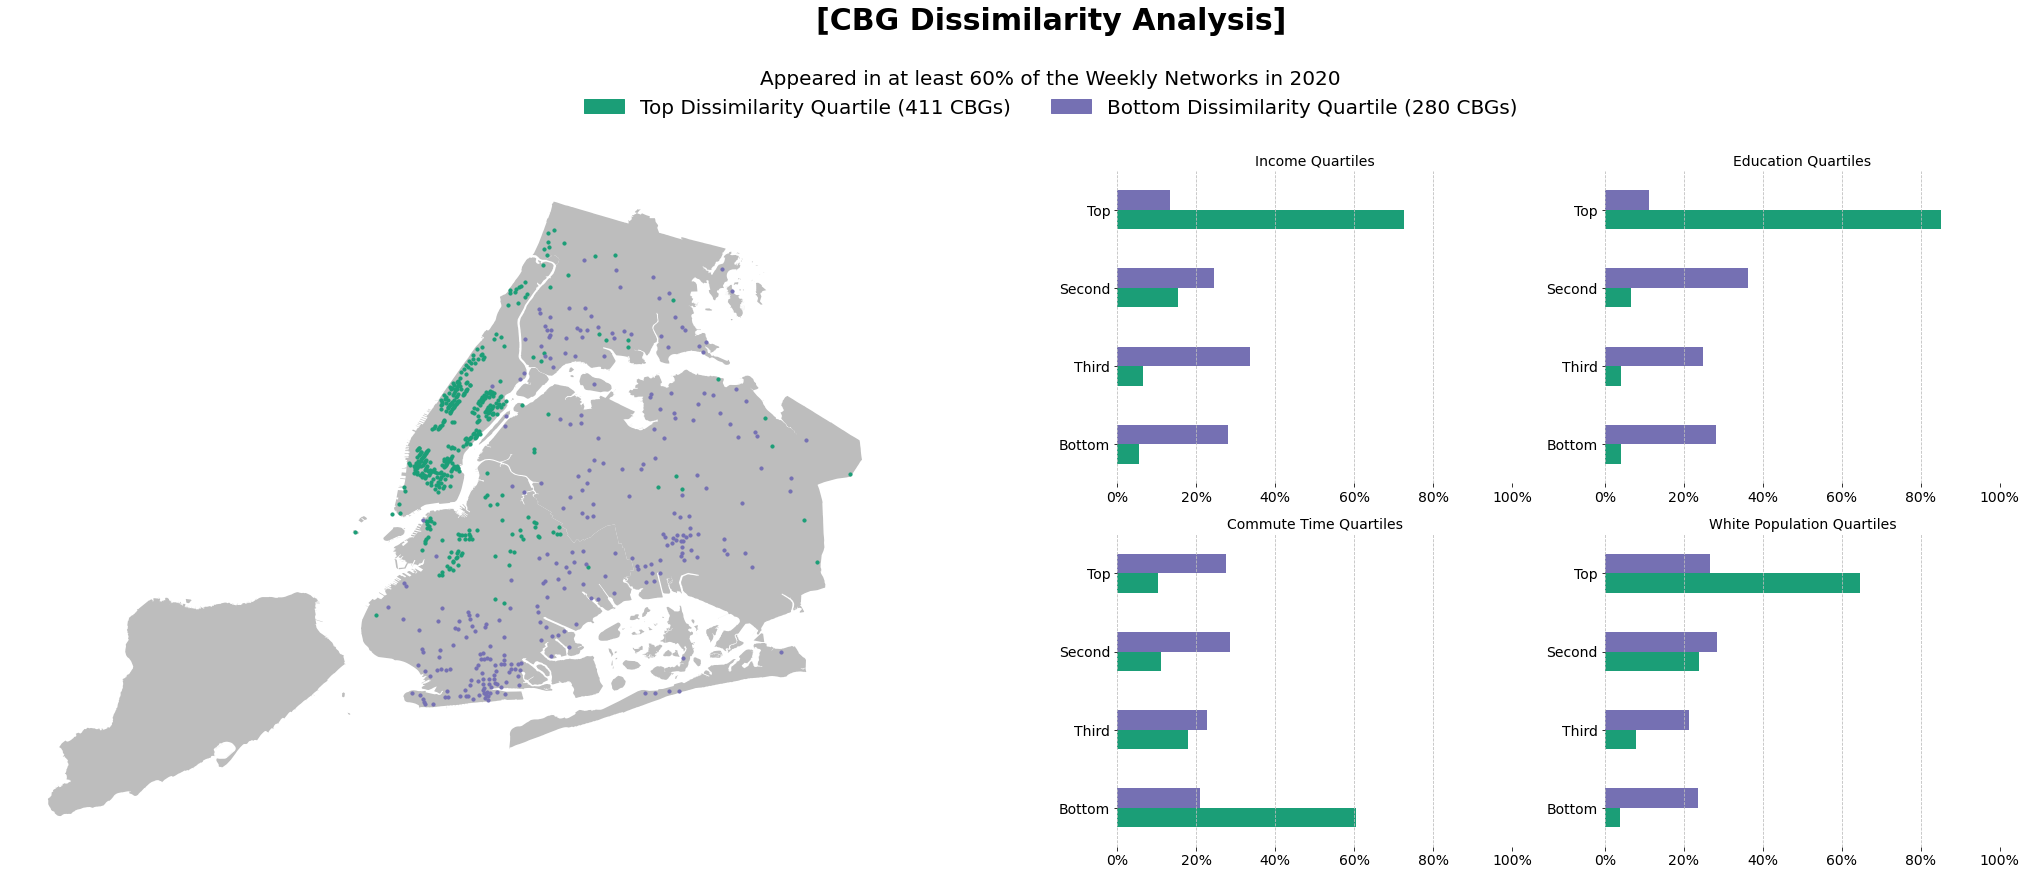

In [25]:
plot_cbgs(filtered_top_cbgs, filtered_bottom_cbgs, fname=f'cbg-change-combined-{threshold}-staten-discarded.pdf')